Mise en place de l'environnement d'analyse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import pickle
from joblib import dump, load

import datetime

sns.set_theme()
%matplotlib inline

# 1 - Description des variables

In [2]:
urgences = pd.read_csv("data/final_preprocess_df.csv", index_col=0, sep=",", encoding="utf8")
urgences.head()

,dateT_E,dateT_S,delta_time,code,age,sex,tri,label,decision,date,...,date_S_AN,date_S_MOIS,date_S_JOUR,date_S_H,date_S_MN,tri_is_missing,identity_is_missing,sortie_is_zero,ferie_chome,school vacation
0,2020-06-29 18:07:00,2020-06-30 20:50:00,26.72,T601,37.7,F,3,Urgence moyenne,Patient admis,2020-06-29,...,2020,6,30,20,50,0,0,0,travail,non
1,2019-10-05 08:05:00,2019-10-06 10:45:00,26.67,T601,26.5,F,3,Urgence moyenne,Patient non admis,2019-10-05,...,2019,10,6,10,45,0,0,0,travail,non
2,2017-01-21 20:30:00,2017-01-22 23:00:00,26.50,T601,25.8,M,4,Lesion stable,Patient décédé,2017-01-21,...,2017,1,22,23,0,0,0,0,travail,oui
3,2017-02-27 13:45:00,2017-02-28 16:00:00,26.25,T601,58.5,M,3,Urgence moyenne,Patient admis,2017-02-27,...,2017,2,28,16,0,0,0,0,travail,non
4,2017-01-05 12:40:00,2017-01-06 14:49:00,26.15,T601,66.4,M,4,Lesion stable,Patient admis,2017-01-05,...,2017,1,6,14,49,0,0,0,FERIE,non


Copie du dataset dans un autre DataFrame pour ne jamais le modifier accidentellement 

In [3]:
df = urgences.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250569 entries, 0 to 250568
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dateT_E              250569 non-null  object 
 1   dateT_S              250569 non-null  object 
 2   delta_time           250569 non-null  float64
 3   code                 250569 non-null  object 
 4   age                  250569 non-null  float64
 5   sex                  250569 non-null  object 
 6   tri                  250569 non-null  int64  
 7   label                250569 non-null  object 
 8   decision             250569 non-null  object 
 9   date                 250569 non-null  object 
 10  year                 250569 non-null  int64  
 11  month                250569 non-null  int64  
 12  day                  250569 non-null  int64  
 13  week_day             250569 non-null  int64  
 14  hour                 250569 non-null  int64  
 15  min              

### On remet nos formats date et date-time

In [5]:
df["dateT_E"] = pd.to_datetime(df.dateT_E)
df["dateT_S"] = pd.to_datetime(df.dateT_S)
df["date"] = pd.to_datetime(df.date)
df["date_S"] = pd.to_datetime(df.date_S)

## Graphiques univariés

### Variable Age
Forte population en bas âge; C'est le seul établissement du pays qui possède des services de pédiatrie et de neonatalogie.
Il est donc naturel qu'il reçoive aussi les urgences.
On note un deuxième pic pour les 20-30 ans.
Le pays a une population jeune, avec une forte accidentologie.


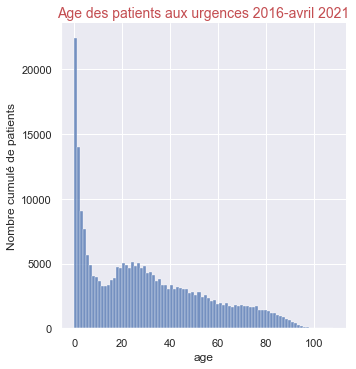

In [6]:
sns.displot(data=df, x="age")
plt.title("Age des patients aux urgences 2016-avril 2021",size = 14,color='r')
plt.ylabel("Nombre cumulé de patients")
plt.show();

### La variable CODE 
Elle represente le service d'urgences : T601 concerne les urgences adultes, T602 les enfants ainsi que les femmes enceintes.
La fréquentation secteur adulte est un peu plus importante.

Text(0, 0.5, 'Nombre cumulé de patients')

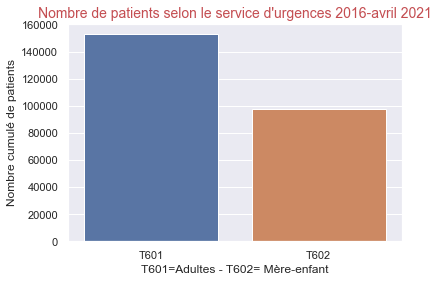

In [7]:
sns.countplot(data=df, x="code")
plt.title("Nombre de patients selon le service d'urgences 2016-avril 2021",size = 14,color='r')   
plt.xlabel("T601=Adultes - T602= Mère-enfant")
plt.ylabel("Nombre cumulé de patients")

### GRAVITE (tri + libellé)
A l'arrivée aux urgences les patients sont triés selon une première estimation des symptômes afin d'organiser une prise en charge plus rapide des patients les plus graves. Le tri est donc un indicateur de sévérité estimée à l'arrivée.
(Les petits tris sont les plus graves.)

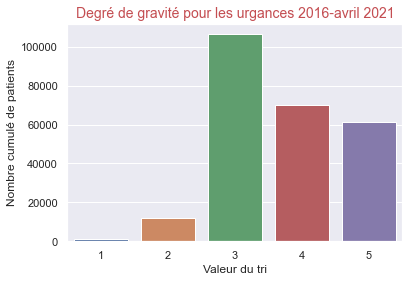

In [8]:
sns.countplot(data=df, x="tri")
plt.title("Degré de gravité pour les urgances 2016-avril 2021",size = 14,color='r')
plt.xlabel("Valeur du tri")
plt.ylabel("Nombre cumulé de patients")
plt.show()

Libellés correspondants aux différents tris

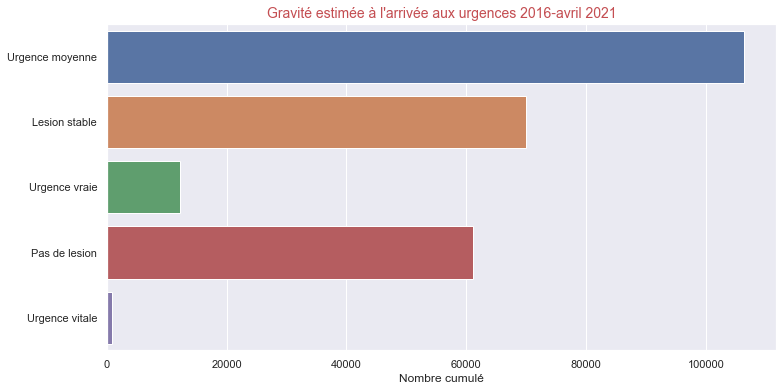

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y="label", orient="h")
plt.title("Gravité estimée à l'arrivée aux urgences 2016-avril 2021",size = 14,color='r')
plt.ylabel("")
plt.xlabel("Nombre cumulé")
plt.show();

### Décision à l'issue de la prise en charge aux urgences.
Dans 3 cas sur 4 le patient repart, dans 25% des cas il est hospitalisé. Un petit nombre décède aux urgences.
La distribution selon la décision est donc très hétérogène.
On en tiendra compte dans la classification.

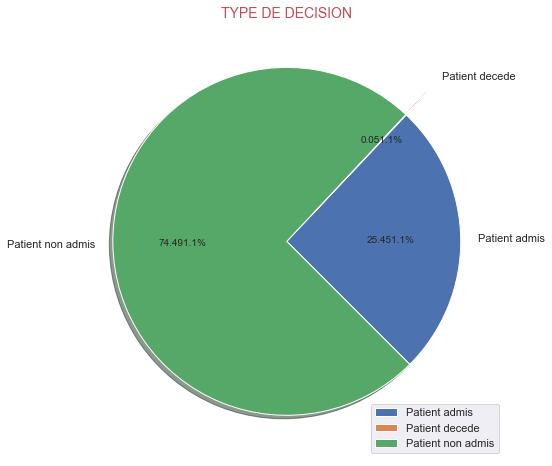

In [10]:
plt.figure(figsize=(8, 8))
labels_count_df = pd.DataFrame(df.groupby("decision").count())
plt.pie(labels_count_df.code,
        labels=['Patient admis','Patient decede','Patient non admis'],
        explode=(0, 0.2, 0),
        autopct=lambda x: str(round(x, 2))+"1.1%",shadow=True, startangle=-45
        )
plt.legend(loc="lower right")
plt.title("TYPE DE DECISION",size = 14,color='r')
plt.show();

## Graphiques multivariés

Nombre de personnes en fonction de la décision & du degré de gravité
On peut voir que la majorité des patients admis & non-admis étaient des patients dont le degré de gravité était de 3 (moyen)

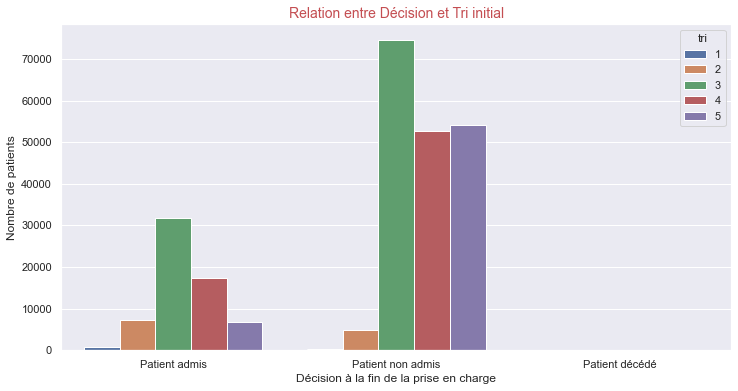

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="decision", hue="tri")
plt.ylabel('Nombre de patients')
plt.xlabel('Décision à la fin de la prise en charge')
plt.title("Relation entre Décision et Tri initial",size = 14,color='r');

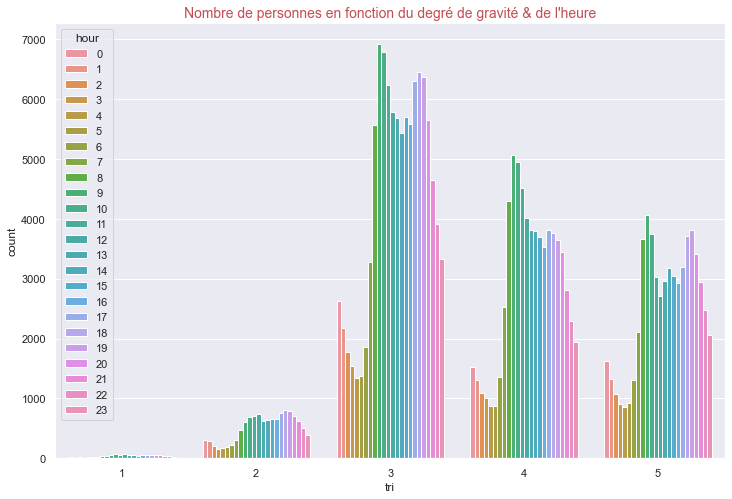

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x="tri", hue="hour")
plt.title("Nombre de personnes en fonction du degré de gravité & de l'heure", size=14,color='r');

### EVOLUTION MENSUELLE DE L'ACTIVITE
On note une sur-activité de mars à mai pour les enfants, surtout en mars chaque année, sauf en 2020, année où il y a eu un confinement.
La fréquentation par les adultes est plus régulière globalement.

On retient aussi une fréquentation plus faible des enfants sur les mois de décembre et janvier (grandes vacances d'été), à l'inverse des adultes.
=> à affiner avec les vacances scolaires

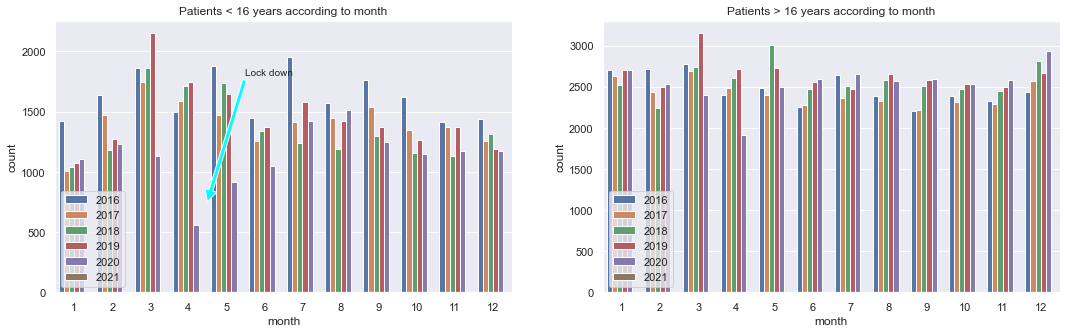

In [13]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
df1=df[(df['age'] < 16) & (df['year'] < 2021)]
p1=sns.countplot(x=df1.month, hue=df.year)
plt.annotate('Lock down',xy=(3.5,750),xytext=(4.5,1800),arrowprops={'facecolor':'cyan'})
plt.legend(loc="lower left")
plt.title('Patients < 16 years according to month');

plt.subplot(1,2,2)
df2=df[(df['age'] >= 16) & (df['year'] < 2021)]
p2=sns.countplot(x=df2.month, hue=df.year)
plt.legend(loc="lower left")
plt.title('Patients > 16 years according to month');



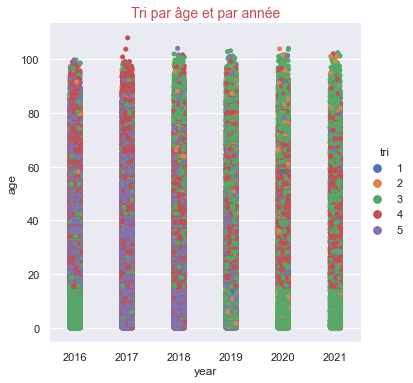

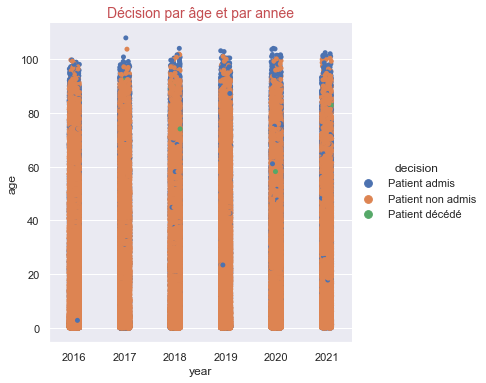

In [14]:
sns.catplot(x="year", y="age" , hue = 'tri', data=df)
plt.title("Tri par âge et par année", size=14, color='r')
plt.show();
sns.catplot(x="year", y="age" , hue = 'decision', data=df)
plt.title("Décision par âge et par année", size=14, color='r')
plt.show();

### EVOLUTION HEBDOMADAIRE 
La fréquentation selon le jour de la semaine montre une prépondérance des adultes le lundi, des enfants sur le week-end.

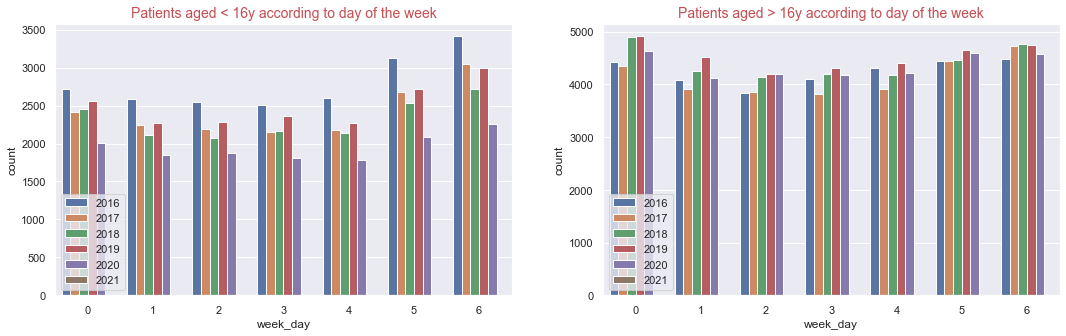

In [15]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
df1=df[(df['age'] < 16)& (df['year']< 2021)]
p1=sns.countplot(x=df1.week_day, hue=df.year)
plt.title("Patients aged < 16y according to day of the week", size=14, color='r')
plt.legend(loc="lower left")
#plt.legend(handles=[plot for plot in plot if plot.get_label() != 2021]); à voir pour enlever 2021 de la legende

plt.subplot(1,2,2)
df2=df[(df['age'] >= 16)& (df['year']< 2021)]
p2=sns.countplot(x=df2.week_day, hue=df.year)
plt.title("Patients aged > 16y according to day of the week", size=14, color='r')
plt.legend(loc="lower left");

### EVOLUTION HORAIRE
En ce qui concerne les heures de la journée, on a plutôt des enfants vers la tranche 17h-20h et les adultes viennent plutôt entre 9h et 12h

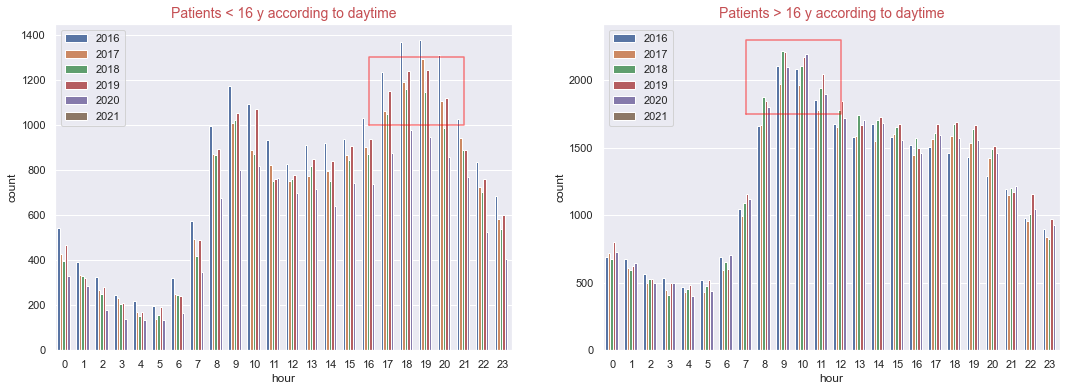

In [16]:
plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.plot([16,21,21,16,16],[1000,1000,1300,1300,1000],color='red',alpha=0.5)
df1=df[(df['age'] < 16) & (df['year'] < 2021)]
p1=sns.countplot(x=df1.hour, hue=df.year)
plt.title("Patients < 16 y according to daytime", size=14, color='r')
plt.legend(loc="upper left");

plt.subplot(1,2,2)
plt.plot([7,12,12,7,7],[1750,1750,2300,2300,1750],color='red',alpha=0.5)
df2=df[(df['age'] >= 16) & (df['year']< 2021)]
p2=sns.countplot(x=df2.hour, hue=df.year)
plt.title("Patients > 16 y according to daytime", size=14, color='r')
plt.legend(loc="upper left");


#### Répartition hebdomadaire des admissions adultes/enfants

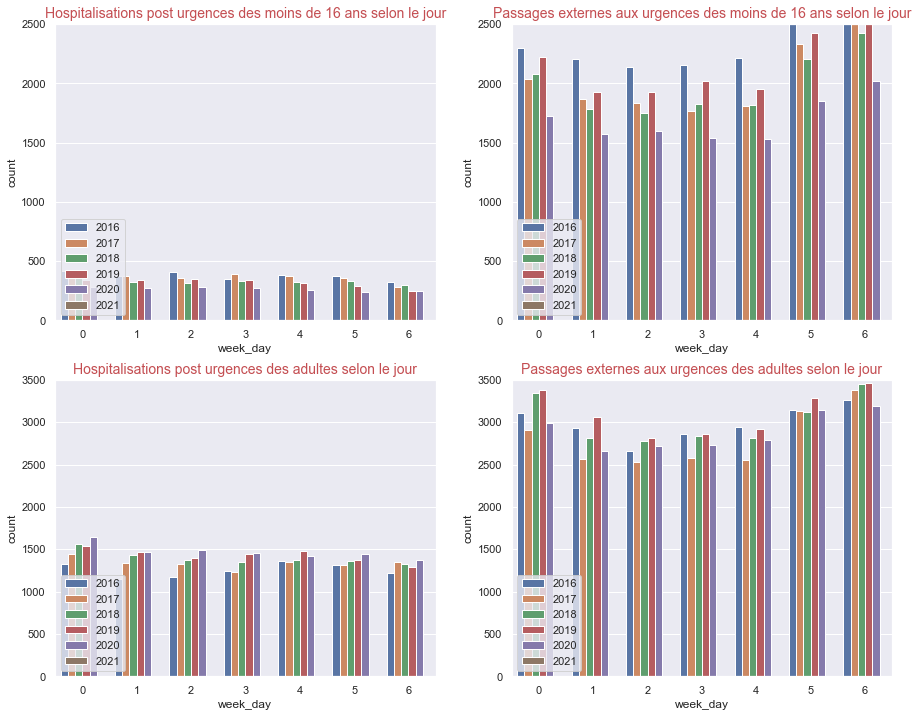

In [17]:
plt.figure(figsize=(15,12))

df_enf_in = df[(df['age'] < 16) & ((df['decision']=='Patient admis')|(df['decision']=='Patient décédé'))& (df['year'] < 2021)]
df_enf_out = df[(df['age'] < 16) & (df['decision']=='Patient non admis')& (df['year'] < 2021)]
df_ad_in = df[(df['age'] >= 16) & ((df['decision']=='Patient admis')|(df['decision']=='Patient décédé'))& (df['year'] < 2021)]
df_ad_out = df[(df['age'] >= 16) & (df['decision']=='Patient non admis')& (df['year'] < 2021)]

plt.subplot(2,2,1)
p1=sns.countplot(x=df_enf_in.week_day, hue=df.year)
plt.title("Hospitalisations post urgences des moins de 16 ans selon le jour", size=14, color='r')
plt.legend(loc="lower left")
plt.ylim([0,2500]);

plt.subplot(2,2,2)
p2=sns.countplot(x=df_enf_out.week_day, hue=df.year)
plt.title("Passages externes aux urgences des moins de 16 ans selon le jour", size=14, color='r')
plt.legend(loc="lower left")
plt.ylim([0,2500]);

plt.subplot(2,2,3)
p3=sns.countplot(x=df_ad_in.week_day, hue=df.year)
plt.title("Hospitalisations post urgences des adultes selon le jour", size=14, color='r')
plt.legend(loc="lower left")
plt.ylim([0,3500]);

plt.subplot(2,2,4)
p4=sns.countplot(x=df_ad_out.week_day, hue=df.year)
plt.title("Passages externes aux urgences des adultes selon le jour", size=14, color='r')
plt.legend(loc="lower left")
plt.ylim([0,3500]);

## SERIE TEMPORELLE

#### On va visualiser la série temporelle matérialisant le nombre total de personnes ayant été à l'hopital.
On rajoute la moyenne mobile sur 2 semaines pour lisser la série temporelle.

On peut voir via la moyenne mobile, qu'on accueille en général entre 100/150 personnes au total par jour.

On a en général une augmentation de l'activité vers le mois de mars.
Il correspond à la rentrée des classes après les vacances d'été. On a souvent des epidémies d'infections respiratoires virales chez les enfants ainsi qu'une forte activité lors des épidémies de dengue.
On a ainsi un pic important à 175 en Mars-Avril 2019 

Les inversions de courbe en mars 2020 et 2021 correspondent les deux fois à un mois de confinement dans le cadre du COVID
Le pays a été considéré COVID free en dehors de ces deux épisodes.
La diminution de l'arrivée des personnes à l'hôpital avec le COVID est classique : les gens ont peur de venir là où sont rassemblés les patients COVID.
on voit plus loin qu'il s'agit surtout de la pédiatrie, et des mouvements externes (qui ne sont pas admis, donc les moins graves)
Cette "peur" de venir à l'hôpital a également été constatée en France métropolitaine.

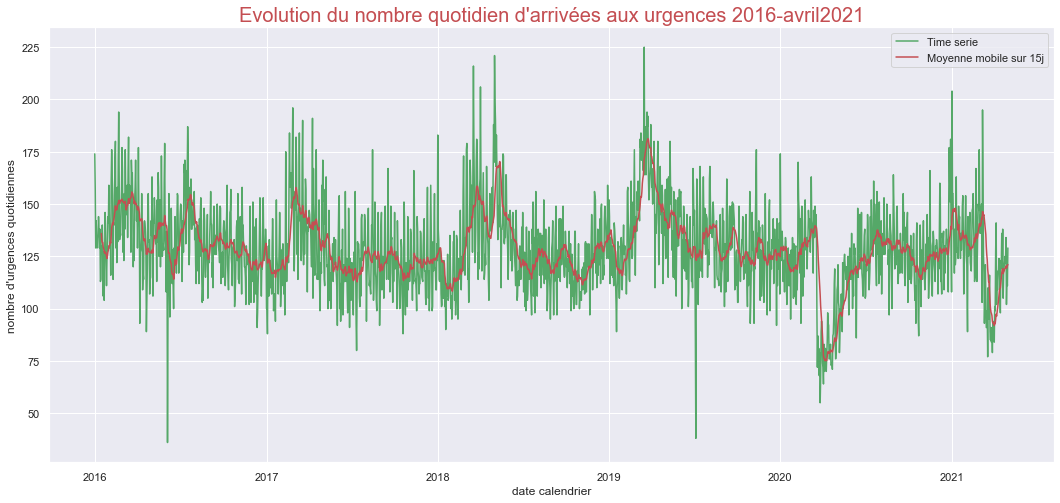

In [18]:
people_by_day = df.date.value_counts().sort_index()

plt.figure(figsize=(18, 8))
plt.plot_date(people_by_day.index, people_by_day.values, "-g", label="Time serie")
plt.plot_date(people_by_day.index, people_by_day.rolling(15).mean(), "-r", label="Moyenne mobile sur 15j")
plt.legend()
plt.title("Evolution du nombre quotidien d'arrivées aux urgences 2016-avril2021",size = 20,color='r')
plt.xlabel("date calendrier")
plt.ylabel("nombre d'urgences quotidiennes")
plt.show();

In [19]:
people = pd.DataFrame(people_by_day)
people.rename({"date": "actual_number"}, axis=1, inplace=True)
people["previous_number"] = people.actual_number.shift(1)
people.dropna(how="any", inplace=True)
people.previous_number = people.previous_number.astype("int")
people.head()

,actual_number,previous_number
2016-01-02,157,174
2016-01-03,129,157
2016-01-04,142,129
2016-01-05,133,142
2016-01-06,129,133


On peut voir que la moyenne du nombre de passage aux urgences est de 129 personnes par jour, avec un écar-type de 21 personnes à la moyenne.

In [20]:
people.describe().actual_number

count    1946.000000
mean      128.671634
std        21.453042
min        36.000000
25%       115.000000
50%       128.000000
75%       141.750000
max       225.000000
Name: actual_number, dtype: float64

La distribution des flux de patients aux urgences semble suivre une loi normale. De plus, graphiquement, il semblerait qu'il y ait une corrélation positive entre le nombre de patients aux urgences le jour j-1 et le nombre de patients le jour j.
On peut faire un test statistique de Pearson pour le vérifier.

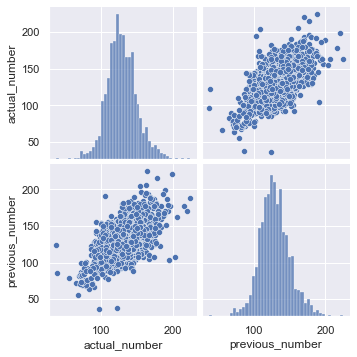

In [21]:
sns.pairplot(people);

#### Relation nombre de patient le jour précédent & nombre de patient le jour suivant.

On veut vérifier l'existence d'une relation entre le nombre de patients sur 2 jours consécutifs. On a 2 variables quantitatives. 
On utilise ainsi le test du coefficient de Pearson:
   * H0: Il n'y a pas de relation entre le nombre de passages aux urgences entre 2 jours consécutifs.
   * H1: On rejette H0 avec un risque maximal de 5%.

In [22]:
pearson = pearsonr(people.actual_number, people.previous_number)
print(f"Corrélation: {100*pearson[0]:.2f}%, p-value: {100*pearson[1]:.8f}%")

Corrélation: 58.32%, p-value: 0.00000000%


Ainsi, on observe une corrélation positive relativement élevée d'environ 60%, accompagnée d'une valeur p < 5%.
On peut donc rejeter l'hypothese nulle et conclure qu'il y a une relation positive entre le passage aux urgences le jour j-1 et le jour j.

## Tests Statistiques

### 1er test: relation âge-jour de la semaine

On veut vérifier l'existence d'une différence d'admissions aux urgences des enfants selon le jour de la semaine.
On a deux variables qualitatives. 
On utilise une loi du Khi 2:
* Hypothèse nulle Ho : il n'y a pas de différence d'admissions pour les enfants selon le jour de la semaine.
* Hypothèse alternative H1 : on rejette H0 avec un risque maximal de 5%

In [23]:
import statsmodels
from scipy.stats import chi2_contingency

df_enf = df[(df['age'] < 16)]
table_contingence = pd.crosstab(df_enf.week_day, df_enf.decision)
table_contingence

decision,Patient admis,Patient décédé,Patient non admis
week_day,,,
0,1892,1,10858
1,1776,1,9731
2,1802,1,9702
3,1770,0,9769
4,1737,0,9808
5,1659,2,12085
6,1476,2,13639


In [24]:
results_test_khi2 = chi2_contingency(table_contingence)
valeur_p = results_test_khi2[1]
valeur_p
print(f"La valeur p du test khi2 est: {100*(valeur_p):.8f}%")

La valeur p du test khi2 est: 0.00000000%


Ainsi, on a une p-value < 5%: on rejette donc l'hypothese nulle selon laquelle il n'y a pas de différence d'admission pour les enfants selon le jour de la semaine.

On va maintenant quantifier la relation entre les variables, pour déterminer le degré de corrélation entre ces variables.

In [25]:
def V_Cramer(table, n):
    """
    This function returns the V Cramer value
    """
    X_2 = chi2_contingency(table)[0]
    N =n
    k = table.shape[1]
    r = table.shape[0]
    
    k_hat = k - ((k-1)**2/(N-1))
    r_hat = r - ((r-1)**2/(N-1))
    phi_2 = max(0, (X_2/N)-((k-1)*(r-1)/(N-1)))
    
    V = (phi_2/(min(k_hat-1, r_hat-1)))**(1/2)
    return V

In [26]:
vcramer = V_Cramer(table_contingence, df.shape[0])
print(f"Le degré de relation entre les 2 variables est de: {100*vcramer:.2f}%")

Le degré de relation entre les 2 variables est de: 2.61%


On a un degré de relation de 1.64% la relation entre ces variables est donc tres faible

### 2eme test: relation âge-label

On veut étudier la relation entre une variable qualitative et une variable quantitative.
Le test approprié est donc le test statistique ANOVA.

On définit l'hypothese nulle:
* H0: La variable quantitative âge n'influe pas sur la variable qualitative label

Et l'hypothese alternative:
* H1: La variable quantitative âge a une influence sur la variable qualitative label

On va s'aider d'un test statistique ANOVA pour rejeter ou pas l'hypothese nulle (dans tous les cas, on ne peut jamais l'accepter.)

In [27]:
import statsmodels.api

result = statsmodels.formula.api.ols(data=df, formula='age ~ label').fit()

In [28]:
table = statsmodels.api.stats.anova_lm(result)
print(f"p-value: {table.iloc[0, -1]}")

p-value: 0.0


On peut remarquer que la p-value (PR(>F)) est inférieure à 5%, on rejette donc l'hypothese nulle selon laquelle l'âge n'influe pas sur le label.